In [1]:
from datetime import datetime, timedelta
import gc
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import xgboost as xgb

SEED = 0

In [2]:
%%time
df_train_identity = pd.read_csv('../input/train_identity.csv')
df_test_identity = pd.read_csv('../input/test_identity.csv')
df_train_transaction = pd.read_csv('../input/train_transaction.csv')
df_test_transaction = pd.read_csv('../input/test_transaction.csv')
df_train = pd.merge(df_train_transaction, df_train_identity, how='left', on='TransactionID')
df_test = pd.merge(df_test_transaction, df_test_identity, how='left', on='TransactionID')

print('Number of Training Examples = {}'.format(df_train_transaction.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test_transaction.shape[0]))
print('Number of Training Examples with Identity = {}'.format(df_train_identity.shape[0]))
print('Number of Test Examples with Identity = {}\n'.format(df_test_identity.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}'.format(df_train['isFraud'].shape))
print('Test X Shape = {}\n'.format(df_test.shape))

del df_train_identity, df_test_identity, df_train_transaction, df_test_transaction
gc.collect()

Number of Training Examples = 590540
Number of Test Examples = 506691

Number of Training Examples with Identity = 144233
Number of Test Examples with Identity = 141907

Training X Shape = (590540, 434)
Training y Shape = (590540,)
Test X Shape = (506691, 433)

CPU times: user 44.2 s, sys: 13.9 s, total: 58.1 s
Wall time: 58.2 s


67

In [3]:
%%time

START_DATE = '2017-12-01'
startdate = datetime.strptime(START_DATE, '%Y-%m-%d')

for df in [df_train, df_test]:
    
    card_cols = ['card1', 'card2', 'card3', 'card5']
    
    for col in card_cols: 
        if '1' in col: 
            df['cardID'] = df[col].map(str)
        else : 
            df['cardID'] += ' ' + df[col].map(str)
    df['cardID_vc'] = df.groupby('cardID')['cardID'].transform('count')                
    
    # Time Features
    # df['TransactionDate'] = df['TransactionDT'].apply(lambda x: (startdate + timedelta(seconds=x)))
    # df['Hour'] = df['TransactionDate'].dt.hour.values
    # df['Day'] = df['TransactionDate'].dt.day.values
    # df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek.values
    # df['Month'] = df['TransactionDate'].dt.month.values
    # df['DayOfYear'] = df['TransactionDate'].dt.dayofyear.values
    # df.drop(columns=['TransactionDate'], inplace=True)    
    # df['HourFrequency'] = df.groupby('Hour')['Hour'].transform('count')
    # df['DayFrequency'] = df.groupby('Day')['Day'].transform('count')
    # df['DayOfWeekFrequency'] = df.groupby('DayOfWeek')['DayOfWeek'].transform('count')
    # df['MonthFrequency'] = df.groupby('Month')['Month'].transform('count')
    # df['DayOfYearFrequency'] = df.groupby('DayOfYear')['DayOfYear'].transform('count')
    
    # Fixing wrong and missing information
    df.loc[df.query('DeviceInfo == "Trident/7.0"').index, 'DeviceInfo'] = 'Windows'
    
    df.loc[df.query('DeviceType.isnull() and id_31 == "ie 11.0 for desktop"', engine='python').index, 'DeviceType'] = 'desktop'
    df.loc[df.query('DeviceType.isnull() and id_31 == "ie 11.0 for tablet"', engine='python').index, 'DeviceType'] = 'mobile'
    
    # Encoding binary features
    true_false_cols = ['id_35', 'id_36', 'id_37', 'id_38']
    found_new_cols = ['id_28']
    found_notfound_cols = ['id_12', 'id_16', 'id_27', 'id_29']
    
    for col in true_false_cols:
        df[col] = df[col].map({'F': 0, 'T': 1})
    for col in found_new_cols:
        df[col] = df[col].map({'New': 0, 'Found': 1})
    for col in found_notfound_cols:
        df[col] = df[col].map({'NotFound': 0, 'Found': 1})
        
    # Feature selection
    df.drop(columns=['TransactionID'], inplace=True)
    
gc.collect()

CPU times: user 8.62 s, sys: 8.92 s, total: 17.5 s
Wall time: 17.6 s


94

In [4]:
%%time

card_rates = {}

unique_cards_train = set(df_train['cardID'].unique())
unique_cards_test = set(df_test['cardID'].unique())
unique_cards_intersection = list(unique_cards_train.intersection(unique_cards_test))


'''df_train['cardUnique'] = 0
df_test['cardUnique'] = 0

df_train['cardUnique'] = (~df_train['cardID'].isin(unique_cards_intersection)).astype(int)
df_test['cardUnique'] = (~df_test['cardID'].isin(unique_cards_intersection)).astype(int)'''

df_card_fraud_rate = df_train.groupby(['cardID', 'isFraud'])['isFraud', 'cardID'].count()


for i in range(len(df_card_fraud_rate)):
    if df_card_fraud_rate.index[i] in unique_cards_intersection and df_card_fraud_rate.iloc[i, 1] > 1:
        card_rates[df_card_fraud_rate.index[i]] = df_card_fraud_rate.iloc[i, 0]

CPU times: user 5.1 s, sys: 0 ns, total: 5.1 s
Wall time: 5.1 s


In [5]:
%%time

for card in unique_cards_intersection:
    train_idx = np.where(df_train['cardID'] == card)[0]
    test_idx = np.where(df_test['cardID'] == card)[0]
    
    vcs = df_train.loc[train_idx]['isFraud'].value_counts()
    if (0 in vcs) is not True:
        rate = 1
    elif (1 in vcs) is not True:
        rate = 0
    else:
        rate = vcs[1] / (vcs[0] + vcs[1])
    
    df_train.loc[train_idx, 'cardRate'] = rate
    df_test.loc[test_idx, 'cardRate'] = rate

CPU times: user 13min 10s, sys: 3.59 s, total: 13min 13s
Wall time: 13min 14s


In [6]:
%%time
mean_fraud_rate = np.mean(df_train['isFraud'])

#df_train[df_train['cardID'].isin(card_rates)].index

df_train['cardID'].map(card_rates).value_counts()

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 62.3 ms


Series([], Name: cardID, dtype: int64)

In [7]:
%%time
# Label Encoding
for feature in df_test.columns:
    if df_train[feature].dtype == 'object' or df_test[feature].dtype == 'object': 
        lbl = LabelEncoder()
        lbl.fit(list(df_train[feature].values) + list(df_test[feature].values))
        df_train[feature] = lbl.transform(list(df_train[feature].values))
        df_test[feature] = lbl.transform(list(df_test[feature].values))
        
gc.collect()

CPU times: user 38.5 s, sys: 56 ms, total: 38.5 s
Wall time: 38.5 s


119

In [8]:
'''X_train['isFraud'] = y_train
device_fingerprint = ['DeviceType', 'DeviceInfo', 'id_23', 'id_30', 'id_31', 'id_32', 'id_33', 'id_35', 'isFraud']
device_test = ['DeviceType', 'DeviceInfo', 'id_23', 'id_30', 'id_31', 'id_32', 'id_33']
X_train[X_train['DeviceInfo'] == 'Trident/7.0'][device_fingerprint]'''

"X_train['isFraud'] = y_train\ndevice_fingerprint = ['DeviceType', 'DeviceInfo', 'id_23', 'id_30', 'id_31', 'id_32', 'id_33', 'id_35', 'isFraud']\ndevice_test = ['DeviceType', 'DeviceInfo', 'id_23', 'id_30', 'id_31', 'id_32', 'id_33']\nX_train[X_train['DeviceInfo'] == 'Trident/7.0'][device_fingerprint]"

In [9]:
'''X_train['isFraud'] = y_train

cards = ['card{}'.format(i) for i in range(1, 7)]
ids = ['id_{}'.format(i) for i in range(12, 39)]
cat_features = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo'] + cards + ids + ['isFraud']

X_train[X_train['isFraud'] == 1][cat_features]'''

"X_train['isFraud'] = y_train\n\ncards = ['card{}'.format(i) for i in range(1, 7)]\nids = ['id_{}'.format(i) for i in range(12, 39)]\ncat_features = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo'] + cards + ids + ['isFraud']\n\nX_train[X_train['isFraud'] == 1][cat_features]"

In [10]:
'''device_info_map = {'Trident/7.0': 'Windows', 'rv:11.0': 'Windows',  'rv:57.0': 'Windows', 'rv:58.0': 'Windows', 'rv:52.0': 'Windows',
                   'rv:59.0': 'Windows', 'rv:48.0': 'MacOS', 'rv:56.0': 'Windows'}

X_train[X_train['DeviceInfo'].str.startswith('rv', na=False)]['DeviceInfo'].value_counts()'''

"device_info_map = {'Trident/7.0': 'Windows', 'rv:11.0': 'Windows',  'rv:57.0': 'Windows', 'rv:58.0': 'Windows', 'rv:52.0': 'Windows',\n                   'rv:59.0': 'Windows', 'rv:48.0': 'MacOS', 'rv:56.0': 'Windows'}\n\nX_train[X_train['DeviceInfo'].str.startswith('rv', na=False)]['DeviceInfo'].value_counts()"

In [11]:
'''for df in [X_train, X_test]:    
    df['domain_name'] = df['P_emaildomain'].str.split('.', expand=True)[0]
    df['pixels'] = df['id_33'].str.split('x', expand=True)[0].astype(float) * df['id_33'].str.split('x', expand=True)[1].astype(float)
    df.drop(columns=['TransactionDT'], inplace=True)
'''


"for df in [X_train, X_test]:    \n    df['domain_name'] = df['P_emaildomain'].str.split('.', expand=True)[0]\n    df['pixels'] = df['id_33'].str.split('x', expand=True)[0].astype(float) * df['id_33'].str.split('x', expand=True)[1].astype(float)\n    df.drop(columns=['TransactionDT'], inplace=True)\n"

In [12]:
'''sparse = []

for df in [X_train, X_test]:
    for feature in df.columns:
        counts = df[feature].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            sparse.append(feature)
            
sparse = list(set(sparse))
sparse'''

'sparse = []\n\nfor df in [X_train, X_test]:\n    for feature in df.columns:\n        counts = df[feature].value_counts()\n        zeros = counts.iloc[0]\n        if zeros / len(df) * 100 > 99.9:\n            sparse.append(feature)\n            \nsparse = list(set(sparse))\nsparse'

In [13]:
'''for df in [X_train, X_test]:
    df.drop(columns=sparse, inplace=True)'''

'for df in [X_train, X_test]:\n    df.drop(columns=sparse, inplace=True)'

In [14]:
%%time
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 1988.89 MB
Memory usage after optimization is: 556.15 MB
Decreased by 72.0%
Memory usage of dataframe is 1705.47 MB
Memory usage after optimization is: 487.27 MB
Decreased by 71.4%
CPU times: user 1min 57s, sys: 5min 8s, total: 7min 5s
Wall time: 7min 6s


In [15]:
'''for df in [X_train, X_test]:
    df['TransactionAmt'] = np.log1p(df['TransactionAmt'])'''

"for df in [X_train, X_test]:\n    df['TransactionAmt'] = np.log1p(df['TransactionAmt'])"

In [16]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='gpu_hist',
    importance_type='weight'
)

gc.collect()

0

In [17]:
X_train = df_train.drop(columns=['isFraud'])
y_train = df_train['isFraud'].copy()
X_test = df_test.copy()

gc.collect()

0

In [18]:
N = 10
tscv = TimeSeriesSplit(n_splits=N)
skf = StratifiedKFold(n_splits=N, shuffle=True, random_state=SEED)

importance = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=X_train.columns)
score = []
y_pred = np.zeros(X_test.shape[0])
oof = np.zeros(X_train.shape[0])

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}'.format(fold))
      
    X_tr, X_vl = X_train.iloc[trn_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[trn_idx], y_train.iloc[val_idx]
    
    clf.fit(X_tr, y_tr)

    predictions = clf.predict_proba(X_vl)[:, 1]
    importance.iloc[:, fold - 1] = clf.feature_importances_
    oof[val_idx] = predictions

    score.append(roc_auc_score(y_vl, predictions))
    print('Fold {} ROC AUC Score {}\n'.format(fold, roc_auc_score(y_vl, predictions)))

    y_pred += clf.predict_proba(X_test)[:, 1] / N
    
    del X_tr, y_tr, X_vl, y_vl, predictions
    gc.collect()
    
print('Average ROC AUC Score {} [STD:{}]'.format(np.mean(score), np.std(score)))

Fold 1
Fold 1 ROC AUC Score 0.9758055566676646

Fold 2
Fold 2 ROC AUC Score 0.9748963140764593

Fold 3
Fold 3 ROC AUC Score 0.9765711928625073

Fold 4
Fold 4 ROC AUC Score 0.9729904500538182

Fold 5
Fold 5 ROC AUC Score 0.9727387624140026

Fold 6
Fold 6 ROC AUC Score 0.9732621228796253

Fold 7
Fold 7 ROC AUC Score 0.9719221853808525

Fold 8
Fold 8 ROC AUC Score 0.9734933941813227

Fold 9
Fold 9 ROC AUC Score 0.9767663167213068

Fold 10
Fold 10 ROC AUC Score 0.9769410861202341

Average ROC AUC Score 0.9745387381357794 [STD:0.0017833365233124602]


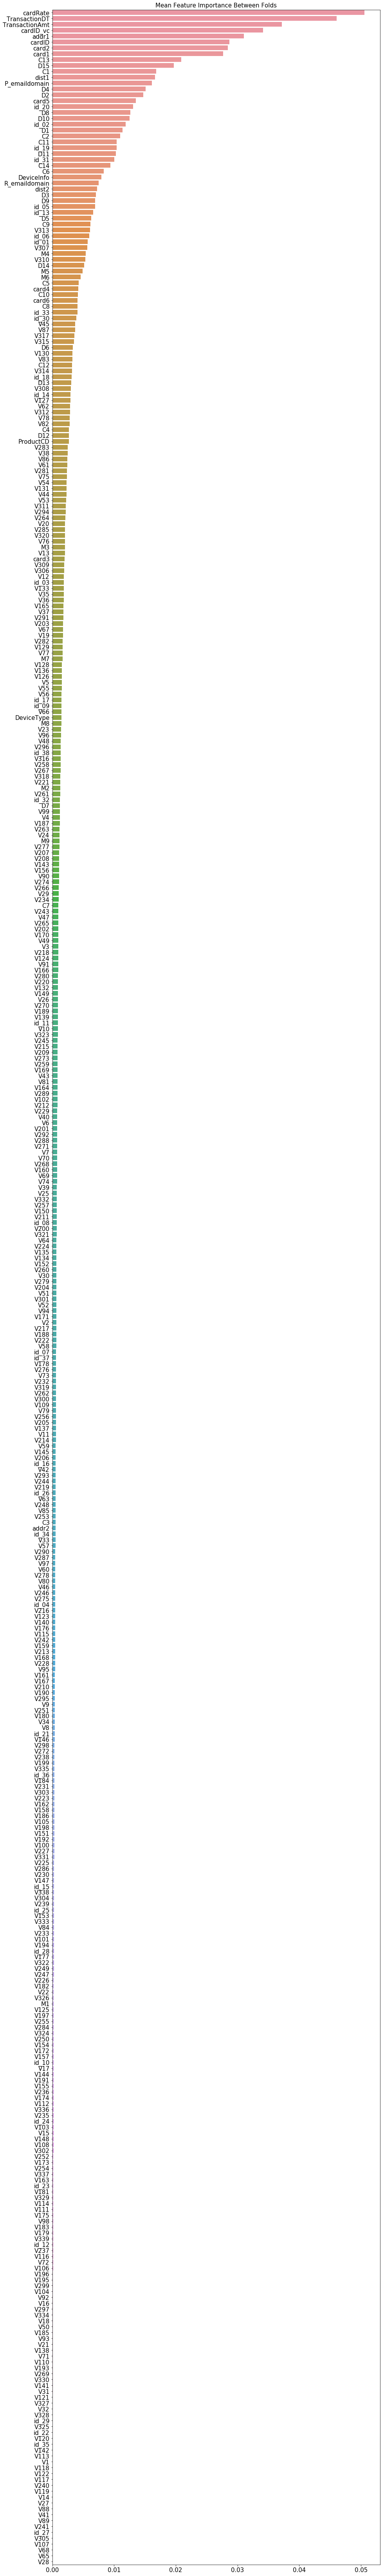

In [19]:
importance['Mean_Importance'] = importance.sum(axis=1) / N
importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 120))
sns.barplot(x='Mean_Importance', y=importance.index, data=importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Mean Feature Importance Between Folds', size=15)

plt.show()

In [20]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')
submission['isFraud'] = y_pred
submission.to_csv('submission.csv')

In [21]:
submission.head()

,isFraud
TransactionID,
3663549,0.000029
3663550,0.001401
3663551,0.000007
3663552,0.000788
3663553,0.001153
